# Building custom datasets for PyTorch

## This notebook demonstrates ability to build custom datasets and train models on those data.

Following along with tutorials from https://www.learnpytorch.io, we create a dataset of images of 3 types of food (Pizza, Steak and Sushi). 

We download the data and explore the file structure programatically. 

Then we build datasets in a couple different ways:

 1. We create an `ImageFolder` dataset using builtin torchvision.datasets.ImageFolder
 2. We create a custom dataset that mimics the functionality of an `ImageFolder` dataset

We convert datasets into DataLoaders and explore transforms inside torchvision to prepare and even augment data. 

We construct a TinyVGG model, following along with https://poloclub.github.io/cnn-explainer/, and train it on our data with and without augmentation. 

Finally, we make a prediction on an image that was not originally in the dataset.




<hr style="border:1px solid black">

# 0. Preliminaries

In [1]:
# Import statements

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from torchinfo import summary
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
import pandas as pd

import os

import random
from PIL import Image

import requests
import zipfile
import pathlib
from pathlib import Path
from tqdm.auto import tqdm
from timeit import default_timer as timer

from typing import Tuple, Dict, List

import helper_functions as hf
import models as m

print(f"PyTorch version is: {torch.__version__}")
print(f"torchvision version is: {torchvision.__version__}")

PyTorch version is: 1.12.0
torchvision version is: 0.13.0


In [2]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is: {device}")

Device is: cpu


In [3]:
# Hyperparameters

BATCH_SIZE = 16
LEARNING_RATE = 0.1
HIDDEN_UNITS = 10

<hr style="border:1px solid black">

# 1. Get some data

In [4]:
# (0). Get Pizza-Steak-Sushi dataset from (Food 101 dataset).

# Setup path to data folder
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesnt exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} dir already exists...skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True,exist_ok=True)

# Download data zipfile from github
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")    
    print("Downloading pizza, steak, sushi data from github...")
    f.write(request.content) 

# Unzip data zipfile.
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi dir already exists...skipping download
Unzipping pizza, steak, sushi data...


Some other ideas of data to make datasets and dataloaders out of...

In [5]:
# (1). Make a dataset out of imagenette2
#
#      This is done in notebook 06_VGG_imagenette_Transfer_Learning.ipynb

In [77]:
# (2). Make a dataset out of spectrograms in TIMIT corresponding to different phonemes
#
#      TO DO.

In [7]:
# (3). Make dataset out of text where X is string of say 50 letters and y is next letter in sequence. To train simple transformer on.
#
#      TO DO.

<hr style="border:1px solid black">

# 2. Explore and prepare the data

In [8]:
# Walk through file structure of downloaded dataset and print out some info

import os

def walk_through_dir(dir_path):
    """
        Walks through dir_path, returning its contents.
    """

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

walk_through_dir(image_path)

There are 2 directories and 1 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


In [9]:
# Set up training and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/1615395.jpg
Image class: steak
Image height: 384
Image width: 512


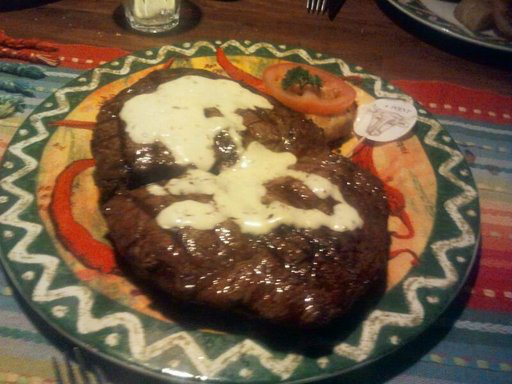

In [10]:
## Visualize an image using PIL

# set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
len(image_path_list)

# 2. Pick a random image using random.choice()
random_image_path = random.choice(image_path_list)
random_image_path

# 3. Get image class name using pathlib.Path.parent.stem
random_image_class = random_image_path.parent.stem
random_image_class

# 4. Open image using Python's PIL
img = Image.open(random_image_path)

# 5. Show image and pring meta data
print(f"Random image path: {random_image_path}")
print(f"Image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


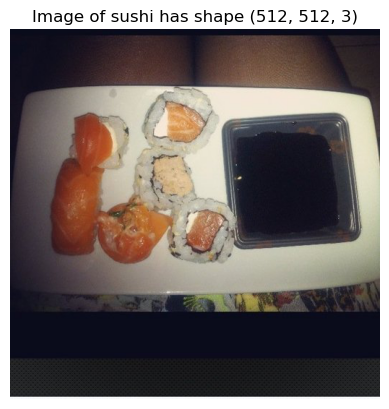

In [11]:
## Visualize an image using Matplotlib

if True:
    
    # set seed
    #random.seed(42)
    
    # 1. Get all image paths
    image_path_list = list(image_path.glob("*/*/*.jpg"))
    len(image_path_list)
    
    # 2. Pick a random image using random.choice()
    random_image_path = random.choice(image_path_list)
    random_image_path
    
    # 3. Get image class name using pathlib.Path.parent.stem
    image_class = random_image_path.parent.stem
    image_class
    
    # 4. Open image using matplotlib
    imgM = plt.imread(fname=random_image_path)
    
    # # 5. Show image and pring meta data
    # print(f"Random image path: {random_image_path}")
    # print(f"Image class: {random_image_class}")
    # print(f"Image height: {img.height}")
    # print(f"Image width: {img.width}")
    
    plt.imshow(imgM)
    plt.axis(False)
    plt.title(f"Image of {image_class} has shape {imgM.shape}");

<hr style="border:1px solid black">

# 2. Transforming the data into Tensors 

* Turn np.arrays into torch.Tensors
* Turn tensors into Dataset `torch.utils.data.Dataset`
* Turn Dataset into DataLoader `torch.utils.data.DataLoader`

## 2a. Transform and visualize random selection of images

In [12]:
# A single data transform that will be applied to both training and test data with ImageFolder dataset

data_transform = transforms.Compose([
        # (1). Resize images to 64x64
        transforms.Resize(size=(64, 64)),
        # (2). Flip the images randomly along horizontal
        transforms.RandomHorizontalFlip(p=0.5),
        # (3). Turn image into torch.Tensor
        transforms.ToTensor()
])

In [13]:
imgT = data_transform(img)

In [14]:
type(imgT), imgT.shape

(torch.Tensor, torch.Size([3, 64, 64]))

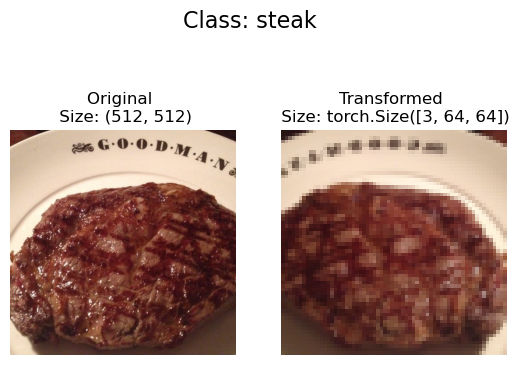

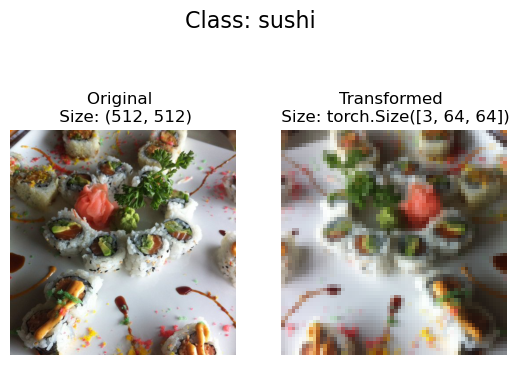

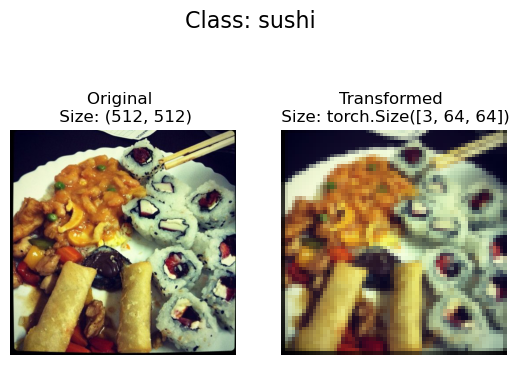

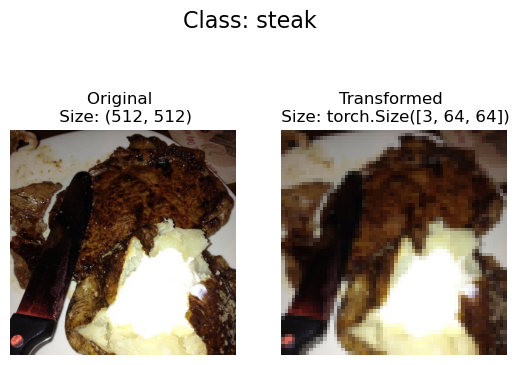

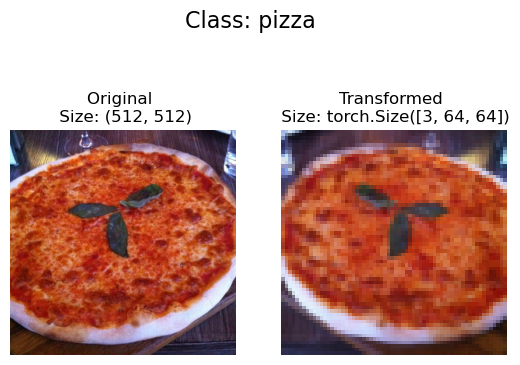

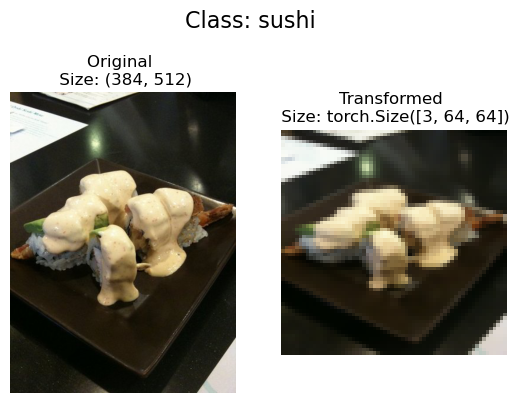

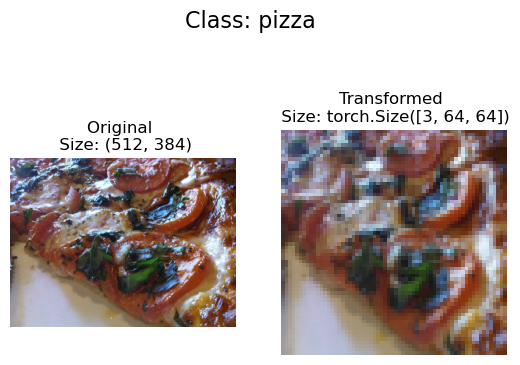

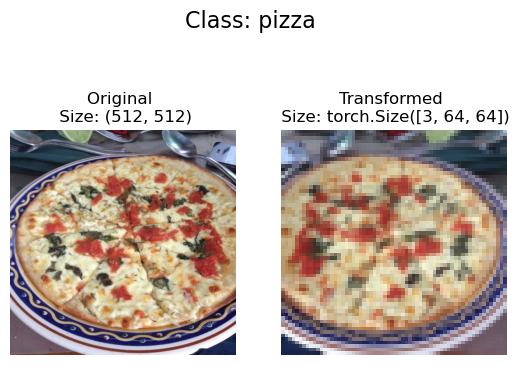

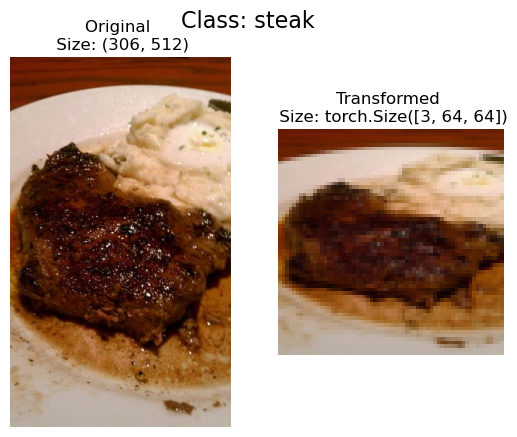

In [81]:
import random
from PIL import Image

def plot_transformed_images(image_paths:list, transforms, n=3, random_seed=None):
    """
        Selects random images from list of image paths and loads/transforms them.
        Plots transformed image and original for each.
    """

    if random_seed:
        random.seed(random_seed)

    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1,ncols=2)

            # Plot original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original \n Size: {f.size}")
            ax[0].axis(False)

            # transform image
            imT = transforms(f)

            # plot transformed image
            ax[1].imshow(imT.permute(1,2,0)) # permute to put color channels last # 
            ax[1].set_title(f"Transformed \n Size: {imT.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

# Run plot transformed images for 10 random datapoints
plot_transformed_images(image_paths = image_path_list,
                        transforms = data_transform,
                        n=10)

## 2b. Option A: Load in dataset using torchvision helper function, `ImageFolder`

In [16]:
# Use torchvision.datasets.ImageFolder to create dataset

train_dataIF = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
 
test_dataIF = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_dataIF, test_dataIF

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
class_names = train_dataIF.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
class_dict = train_dataIF.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_dataIF), len(test_dataIF)

(225, 75)

In [20]:
train_dataIF.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
# train_dataIF.targets

Image shape: torch.Size([3, 64, 64]) | dtype: torch.float32
Label: 0 | dtype: <class 'int'>


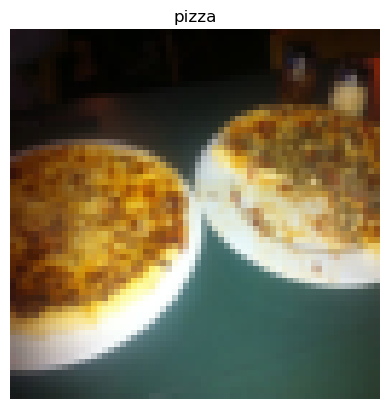

In [22]:
# Look at one sample from the dataset
img, lbl = train_dataIF[0]

print(f"Image shape: {img.shape} | dtype: {img.dtype}")
print(f"Label: {lbl} | dtype: {type(lbl)}")


hf.imshow_img(img)
plt.title(class_names[lbl])
plt.axis(False);

## 2c. Turn Dataset into DataLoader

In [23]:
# Turn train & test datasets into DataLoader

train_dataloaderIF = DataLoader(dataset = train_dataIF,
                              batch_size = BATCH_SIZE,
                              num_workers = 0, #os.cpu_count(),
                              shuffle = True)

test_dataloaderIF = DataLoader(dataset = test_dataIF,
                             batch_size = BATCH_SIZE,
                             num_workers = 0, #os.cpu_count(),
                             shuffle = False)

print(f"Train dataset has {len(train_dataloaderIF)} batches of size {BATCH_SIZE}")
print(f"Test dataset has {len(test_dataloaderIF)} batches of size {BATCH_SIZE}")

Train dataset has 15 batches of size 16
Test dataset has 5 batches of size 16


In [24]:
img, lbl = next(iter(train_dataloaderIF))

print(f"img shape = {img.shape}")
print(f"lbl shape = {lbl.shape}")

img shape = torch.Size([16, 3, 64, 64])
lbl shape = torch.Size([16])


## 2d. Option B: Create a custom dataset to load image data

Want dataset to be able to:
* load images from files
* get class names from dataset
* get classes as dictionary from dataset

In [25]:
# Create helper function to get class names.

# Setup path for target dir.
target_dir = train_dir

print(f"Target dir: {target_dir}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
# Helper function to get class names.

def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """
        Find class names by getting all subdirectory names in target directory.
            
        Assumes target directory is in standard image classification format.
    
        Args:
            directory (str): target directory to load classnames from.
    
        Returns:
            Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
        
        Example:
            find_classes("food_images/train")
            >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """

    # 1. Get class names by scanning target directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # 2. Raise error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}... Please check file structure.")

    # 3. Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [27]:
# Create custom dataset to replicate what ImageFolder dataset does

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform=None):

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        # Setup transform
        self.transform = transform

        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index:int) -> Image.Image:
        """ Opens an image via a path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """ Returns total number of samples"""
        return len(self.paths)

    # 6. Overwrite __getitem__() to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """ Returns one sample of data and label (X,y) given index"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects file structure like targ_dir/class_name/imageXYZ.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx


In [28]:
# Create transforms for train and test datasets. 
# Note: Simple data augmentation on train transform. None on test transform.

train_transforms = transforms.Compose([
                            transforms.Resize(size=(64,64)),
                            transforms.RandomHorizontalFlip(p=0.5), # Data Augmentation
                            transforms.ToTensor()   
                                    ])

test_transforms = transforms.Compose([
                            transforms.Resize(size=(64,64)),
                            transforms.ToTensor()
                                    ])

In [29]:
# Test out ImageFolderCustom

train_dataC = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_dataC = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [30]:
train_dataC, test_dataC

(<__main__.ImageFolderCustom at 0x7fd741a58d90>,
 <__main__.ImageFolderCustom at 0x7fd741a58ac0>)

In [31]:
print(f"Length of training data is (with ImageFolder): {len(train_dataIF)} and with Custom: {len(train_dataC)}")
print(f"Length of test data is (with ImageFolder): {len(test_dataIF)} and with Custom: {len(test_dataC)}")

Length of training data is (with ImageFolder): 225 and with Custom: 225
Length of test data is (with ImageFolder): 75 and with Custom: 75


In [32]:
train_dataC.classes

['pizza', 'steak', 'sushi']

In [33]:
train_dataC.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [34]:
# Check for equality between ImageFolder and ImageFolderCustom attributes
print(train_dataC.classes == train_dataIF.classes)
print(test_dataC.classes == test_dataIF.classes)
print(train_dataC.class_to_idx == train_dataIF.class_to_idx)
print(test_dataC.class_to_idx == test_dataIF.class_to_idx)


True
True
True
True


## 2e. Visualize some random sample images from dataset and custom dataset

In [35]:
# Helper function to display random images from Dataset.

# 1. Create function to take in dataset
def display_random_images(dataset: Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Limit max n
    if n > 10:
        n = 10
        print(f"Max n value is 10. And shutting off display_shape")
        display_shape=False

    # 3. Set random seed for reproducability
    if seed:
        random.seed(seed)

    # 4. Get list of random sample indexes
    random_samples_idx = random.sample(range(len(dataset)),k=n)

    # 5. Loop through random sample indexes and plot with matplotlib
    plt.figure(figsize=(16,8))
    for i,idx in enumerate(random_samples_idx):
        targ_img, targ_lbl = dataset[idx]
        plt.subplot(1,n,i+1)
        hf.imshow_img(targ_img)
        plt.axis(False)
        title = ""
        if classes:
            title = title + f"Class: {classes[targ_lbl]}"
        if display_shape:
            title = title + f"\n {targ_img.shape}"
        plt.title(title, fontsize=10)

In [36]:
# Display images from dataset made from ImageFolder

display_random_images(test_dataIF, 
                      classes=class_names,
                      n=5)

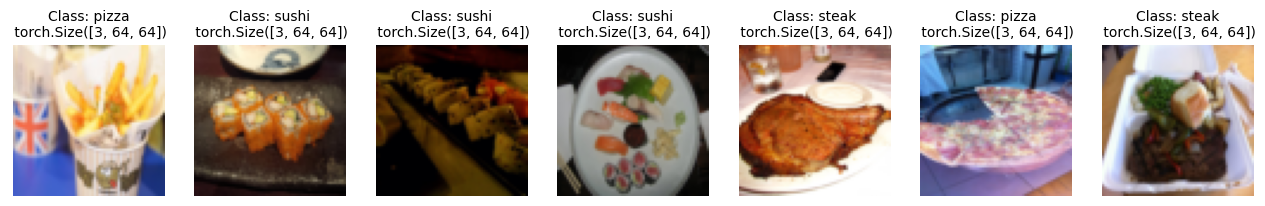

In [37]:
# Display images from custom dataset

display_random_images(train_dataC, 
                      classes=class_names,
                      n=7)

## 2f. Turn Custom dataset into DataLoaders

In [38]:
# Turn train & test datasets into DataLoader

train_dataloaderC = DataLoader(dataset = train_dataC,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0, #os.cpu_count(),
                                     shuffle = True)

test_dataloaderC = DataLoader(dataset = test_dataC,
                                    batch_size = BATCH_SIZE,
                                    num_workers = 0, #os.cpu_count(),
                                    shuffle = False)

print(f"Custom train dataset has {len(train_dataloaderC)} batches of size {BATCH_SIZE}")
print(f"Custom test dataset has {len(test_dataloaderC)} batches of size {BATCH_SIZE}")

Custom train dataset has 15 batches of size 16
Custom test dataset has 5 batches of size 16


In [39]:
# Get image and label from custom data loader

imgC, lblC = next(iter(train_dataloaderC))

imgC.shape, lblC

(torch.Size([16, 3, 64, 64]),
 tensor([1, 2, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0]))

<hr style="border:1px solid black">

# 3. Data Augmentation using transforms

In [40]:
# Add trivialAugmentWide to composition of transforms.

train_transformsAug = transforms.Compose([
                            transforms.Resize(size=(224,224)),
                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                            transforms.ToTensor()
    
])

test_transformsAug = transforms.Compose([
                            transforms.Resize(size=(224,224)),
                            transforms.ToTensor()
    
])

In [41]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10] # show some

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

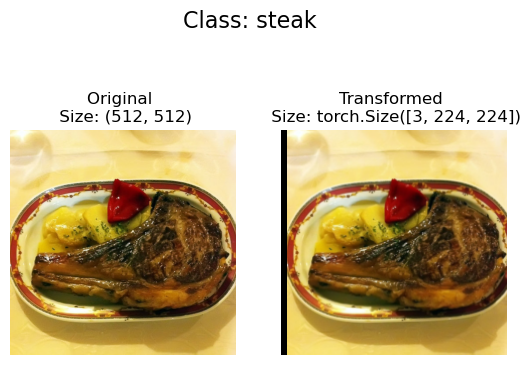

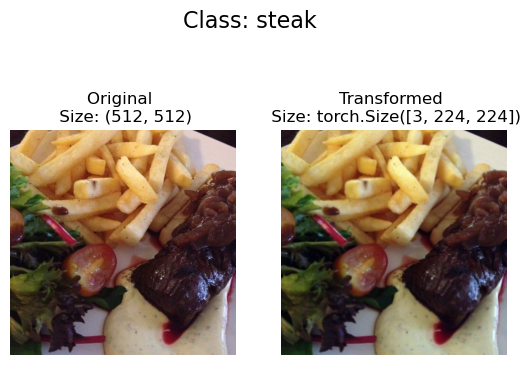

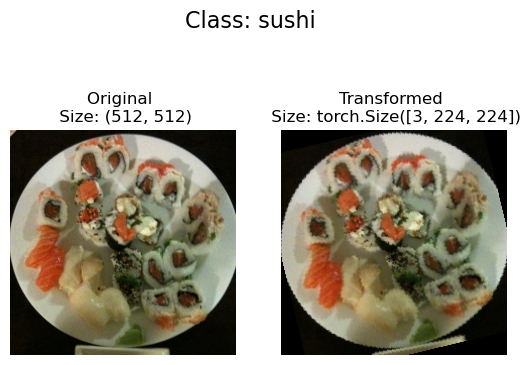

In [42]:
# Plot random transformed images

plot_transformed_images(image_paths = image_path_list,
                        transforms = train_transformsAug,
                        n = 3)

<hr style="border:1px solid black">

# 4. Train models

## 4a. Model_0 - Replicate TinyVGG model without data augmentation for baseline comparison.

In [43]:
# Create transforms and load data for model0

simple_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [44]:
# Create Dataset from torchvision's ImageFolder dataset

train_dataS = datasets.ImageFolder(root = train_dir,
                                 transform = simple_transforms,
                                 target_transform=None)

test_dataS = datasets.ImageFolder(root = train_dir,
                                 transform = simple_transforms,
                                 target_transform=None)



In [45]:
# Create DataLoaders from Datasets.

train_dataloaderS = DataLoader(dataset = train_dataS,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=0) #os.cpu_count())

test_dataloaderS = DataLoader(dataset = test_dataS,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers=0) #os.cpu_count()) 

In [46]:
# Load in one batch of data and display shapes

imgS,lblS = next(iter(train_dataloaderS))

imgS.shape, lblS.shape

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [47]:
%%writefile going_modular/model_builder.py 
# if %%writefile line uncommented, this cell will be written to .py file

# Class TinyVGG model 
import torch
from torch import nn

class TinyVGG(nn.Module):
    """
    Replicate TinyVGG from CNN Explainer website - https://poloclub.github.io/cnn-explainer/

    Network has 2 convolution blocks (Conv2d -> Relu -> Conv2d -> Relu -> MaxPool)
        followed by 1 classifier block, which is just a linear layer.

    :args:
        :input_shape: (int) - number of color channels
        :hidden_units: (int) - designer's choice (10 on explainer)
        :output_shape: (int) - number of classes
        :x: (Tensor) - input image of shape [batch, colorchans, height, width]
        :verbose: (bool) - Flag to enter verbose mode and print out shape of data after each block

    :returns:
        :y_logits: (Tensor) - raw outputs from model must be converted into probs (by softmax) and preds (by argmax)
    """


    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()

        self.conv_layer1 = nn.Conv2d(in_channels = input_shape,
                                     out_channels = hidden_units,
                                     kernel_size = 3,
                                     stride = 1,
                                     padding = 0)

        self.relu = nn.ReLU()
        
        self.conv_layer2 = nn.Conv2d(in_channels = hidden_units,
                                     out_channels = hidden_units,
                                     kernel_size = 3,
                                     stride = 1,
                                     padding = 0)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                    stride = 2,
                                    padding = 0)

        self.flatten = nn.Flatten()

        self.linear_layer = nn.Linear(in_features = hidden_units*13*13,
                                      out_features = output_shape)
                                        

    def forward(self, 
                X: torch.Tensor, 
                verbose: bool = False) -> torch.Tensor:

        if verbose: print(f"Input image: {X.shape} \n")

        # Convolutional Block # 1
        if verbose: print("Convolutional Block #1")
            
        z = self.relu( self.conv_layer1(X) )
        if verbose: print(f"   After conv & relu 1: {z.shape}")
            
        z = self.relu( self.conv_layer2(z) )
        if verbose: print(f"   After conv & relu 2: {z.shape}")

        z = self.maxpool(z)
        if verbose: print(f"   After maxpool1: {z.shape} \n")


        # Convolutional Block # 2
        if verbose: print("Convolutional Block #2")
            
        z = self.relu( self.conv_layer2(z) )
        if verbose: print(f"   After conv & relu 3: {z.shape}")
            
        z = self.relu( self.conv_layer2(z) )
        if verbose: print(f"   After conv & relu 4: {z.shape}")

        z = self.maxpool(z)
        if verbose: print(f"   After maxpool2: {z.shape} \n")

        # Classifier Block
        if verbose: print("Classifier Block")

        z = self.flatten(z)
        if verbose: print(f"   After flatten: {z.shape}")

        z = self.linear_layer(z)
        if verbose: print(f"   After linear: {z.shape}")

        return z
    

Overwriting going_modular/model_builder.py


In [48]:
from going_modular.model_builder import TinyVGG

COLOR_CHANS = 3

torch.manual_seed(42)

model0 = TinyVGG(input_shape = COLOR_CHANS,
                 hidden_units = HIDDEN_UNITS,
                 output_shape = len(class_names)).to(device)

In [49]:
# Run an image through model with verbose on to get shapes
# as input flows through differnt model layers.

z = model0(imgS.to(device), verbose=True)

Input image: torch.Size([16, 3, 64, 64]) 

Convolutional Block #1
   After conv & relu 1: torch.Size([16, 10, 62, 62])
   After conv & relu 2: torch.Size([16, 10, 60, 60])
   After maxpool1: torch.Size([16, 10, 30, 30]) 

Convolutional Block #2
   After conv & relu 3: torch.Size([16, 10, 28, 28])
   After conv & relu 4: torch.Size([16, 10, 26, 26])
   After maxpool2: torch.Size([16, 10, 13, 13]) 

Classifier Block
   After flatten: torch.Size([16, 1690])
   After linear: torch.Size([16, 3])


In [50]:
# An alternative to running model in verbose mode to get shapes as 
# input propagates through model is to use torchinfo.summary

summary(model0, input_size = [16,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [16, 3]                   --
├─Conv2d: 1-1                            [16, 10, 62, 62]          280
├─ReLU: 1-2                              [16, 10, 62, 62]          --
├─Conv2d: 1-3                            [16, 10, 60, 60]          910
├─ReLU: 1-4                              [16, 10, 60, 60]          --
├─MaxPool2d: 1-5                         [16, 10, 30, 30]          --
├─Conv2d: 1-6                            [16, 10, 28, 28]          (recursive)
├─ReLU: 1-7                              [16, 10, 28, 28]          --
├─Conv2d: 1-8                            [16, 10, 26, 26]          (recursive)
├─ReLU: 1-9                              [16, 10, 26, 26]          --
├─MaxPool2d: 1-10                        [16, 10, 13, 13]          --
├─Flatten: 1-11                          [16, 1690]                --
├─Linear: 1-12                           [16, 3]                 

## 4b. Create train_step and test_step functions and put them in training loop

In [51]:
%%writefile going_modular/engine.py 
# if %%writefile line uncommented, this cell will be written to .py file

import torch
from torch import nn

def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device:torch.device):
    """
    Train step for model.
    """

    # set model into train mode to track gradients
    model.train()

    # initialize loss and accuracy to 0
    train_loss, train_acc = 0, 0

    # Loop through batches of data
    for img,lbl in dataloader:

        # Transfer data to device
        img, lbl = img.to(device), lbl.to(device)

        # Forward pass
        y_logits = model(img)

        # Calculate Loss
        loss = loss_fn(y_logits, lbl)
        train_loss += loss.item() # accumulate over batches

        # Convert logit -> probability -> prediction
        y_preds = y_logits.softmax(dim=1).argmax(dim=1)

        # Compute Accuracy
        #acc = accuracy_fn(y_preds, lbl)
        acc = (y_preds==lbl).sum()/len(lbl)
        train_acc += acc.item() # accumulate over batches

        # Zero gradients on optimizer
        optimizer.zero_grad()

        # Compute backward gradients for backprop
        loss.backward()

        # Perform gradient descent
        optimizer.step()


    # Divide accumulated loss/accuracy by number of batches to get average
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc
    

Overwriting going_modular/engine.py


In [52]:
%%writefile -a going_modular/engine.py 
# if %%writefile line uncommented, this cell will be written to .py file

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device:torch.device):
    """
    Test step for model
    """

    # Set model in evaluation mode
    model.eval()

    # Set loss and acc to 0 to accumulate over batches
    test_loss, test_acc = 0, 0

    # Put torch in inference mode
    with torch.inference_mode():

        # Loop through batches of data
        for img,lbl in dataloader:

            # Transfer data to device
            img, lbl = img.to(device), lbl.to(device)

            # Forward pass
            y_logits = model(img)

            # Calculate Loss
            loss = loss_fn(y_logits, lbl)
            test_loss += loss.item() # accumulate over batches
    
            # Convert logit -> probability -> prediction
            y_preds = y_logits.softmax(dim=1).argmax(dim=1)
    
            # Compute Accuracy
            #acc = accuracy_fn(y_preds, lbl)
            acc = (y_preds==lbl).sum()/len(lbl)
            
            test_acc += acc.item() # accumulate over batches

        # Divide accumulated loss/accuracy by number of batches to get average
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

    return test_loss, test_acc
        

Appending to going_modular/engine.py


In [53]:
%%writefile -a going_modular/engine.py 
# if %%writefile line uncommented, this cell will be written to .py file

from tqdm.auto import tqdm
from timeit import default_timer as timer

# Training Loop

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer, 
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device:torch.device = "cpu"):

    # Create empty results dictionary to fill with performance metrics during training
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}    
    
    # # Check and print out which device model and data are on
    # print(f"Model is on {next(model.parameters()).device}")
    # print(f"Training data (from DataLoader) is on {next(iter(train_dataloader))[0].device}")
    # print(f"Test data (from DataLoader) is on {next(iter(test_dataloader))[0].device}")
    
    for epoch in tqdm(range(epochs)):

        epoch_start = timer()
    
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader, #_custom,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
    
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader, #_custom,
                                        loss_fn=loss_fn,
                                        device=device)
    
        epoch_fin = timer()
        
        # Print out whats happening for each epoch
        print(f"Epoch: {epoch:3d} | Train - Loss {train_loss:.5f} - Acc {train_acc*100:.2f}% :|: Test Loss {test_loss:.5f} - Acc {test_acc*100:.2f}% :|: Time: {epoch_fin-epoch_start:.5f} sec")
    
        # Collect up evaluation metrics during training loop for later plotting
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results    

Appending to going_modular/engine.py


In [54]:
# Hyperparams

EPOCHS = 40
LEARNING_RATE = 0.001
HIDDEN_UNITS = 20

In [55]:
# Define Loss, Optimizer and Accuracy Metric

loss_fn = nn.CrossEntropyLoss() # for multi-class classification

optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr=LEARNING_RATE)

accuracy_fn = Accuracy(task='multiclass',num_classes=len(class_names))

In [56]:
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

from going_modular.engine import train
from timeit import default_timer as timer

start_time = timer()

results0 = train(model = model0,
                 train_dataloader = train_dataloaderS,
                 test_dataloader = test_dataloaderS,
                 optimizer = optimizer,  
                 loss_fn = loss_fn,
                 epochs = EPOCHS,
                 device = device)

end_time = timer()

print(f"Total training time: {end_time-start_time:.5} seconds.")

  0%|          | 0/40 [00:00<?, ?it/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch:   0 | Train - Loss 1.10142 - Acc 29.17% :|: Test Loss 1.09503 - Acc 33.33% :|: Time: 21.82397 sec
Epoch:   1 | Train - Loss 1.08822 - Acc 37.08% :|: Test Loss 1.07836 - Acc 46.25% :|: Time: 17.75818 sec
Epoch:   2 | Train - Loss 1.03546 - Acc 53.33% :|: Test Loss 1.01723 - Acc 42.50% :|: Time: 9.51640 sec
Epoch:   3 | Train - Loss 1.02295 - Acc 45.42% :|: Test Loss 0.88643 - Acc 62.92% :|: Time: 2.25906 sec
Epoch:   4 | Train - Loss 0.86241 - Acc 58.75% :|: Test Loss 0.82518 - Acc 62.92% :|: Time: 2.16709 sec
Epoch:   5 | Train - Loss 0.90399 - Acc 53.33% :|: Test Loss 0.80921 - Acc 64.17% :|: Time: 2.16341 sec
Epoch:   6 | Train - Loss 0.78697 - Acc 64.17% :|: Test Loss 0.76717 - Acc 69.58% :|: Time: 2.14793 sec
Epoch:   7 | Train - Loss 0.88248 - Acc 61.25% :|: Test Loss 0.72161 - Acc 70.42% :|: Time: 2.12150 sec
Epoch:   8 | Train - Loss 0.79457 - Acc 65.00% :|: Test Loss 0.72492 - Acc 71.25% :|: Time: 2.04536 sec
Epoch:   9 | Train - Loss 0.80384 - Acc 65.42% :|: Test Loss 0

In [57]:
results0.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

## 4c. Visualize results for model trained using simple transforms

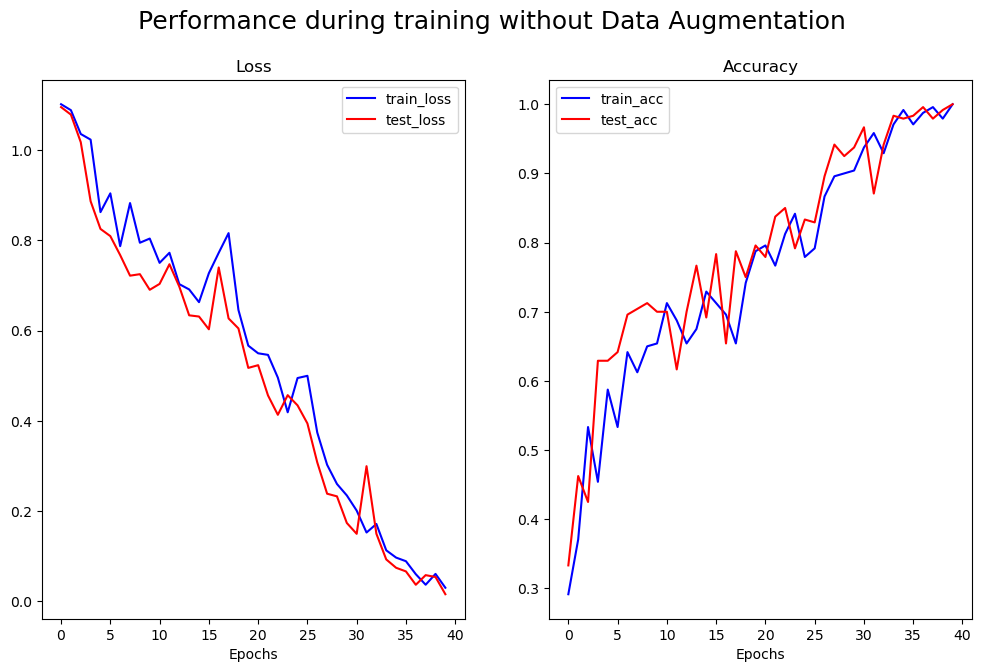

In [58]:
# Plot loss curves during training

def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plots training loss curves of a results dictionary. """

    # Determine how many epochs there were
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12,7))

    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, results["train_loss"], label="train_loss", c='b')
    plt.plot(epochs, results["test_loss"], label="test_loss", c='r')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, results["train_acc"], label="train_acc", c='b')
    plt.plot(epochs, results["test_acc"], label="test_acc", c='r')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(results0);
plt.suptitle('Performance during training without Data Augmentation', fontsize=18);

<hr style="border:1px solid black">

# 5. Train models

## 5a. Model1 - Replicate TinyVGG model with data augmentation (TrivialAugment).

In [59]:
# Add trivialAugmentWide to composition of transforms.

train_transformsA = transforms.Compose([
                            transforms.Resize(size=(64,64)),
                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                            transforms.ToTensor()
    
])

test_transformsA = transforms.Compose([
                            transforms.Resize(size=(64,64)),
                            transforms.ToTensor()
    
])

In [60]:
# Create datasets using Augmentation transforms

train_datasetA = datasets.ImageFolder(root = train_dir,
                                      transform = train_transformsA,
                                      target_transform = None)

test_datasetA = datasets.ImageFolder(root = test_dir,
                                     transform = test_transformsA,
                                     target_transform = None)

In [61]:
# Create dataloaders using Augmentation transforms

train_dataloaderA = DataLoader(dataset = train_datasetA,
                               batch_size = BATCH_SIZE,
                               shuffle = True,
                               num_workers=0)

test_dataloaderA = DataLoader(dataset = test_datasetA,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=0)

In [62]:
# Instantiate model1 the same as model0

model1 = TinyVGG(input_shape = COLOR_CHANS,
                 hidden_units = HIDDEN_UNITS,
                 output_shape = len(class_names)).to(device)

In [63]:
#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

# Define Optimizer (CrossEntropy loss function defined in train function)
optimizer = torch.optim.Adam(params=model1.parameters(),
                            lr=LEARNING_RATE)

start_time = timer()

results1 = train(model = model1,
                 train_dataloader = train_dataloaderA, 
                 test_dataloader = test_dataloaderA,   
                 optimizer = optimizer,  
                 epochs = EPOCHS,
                 device = device)

end_time = timer()

print(f"Total training time: {end_time-start_time:.5} seconds.")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0 | Train - Loss 1.10278 - Acc 32.50% :|: Test Loss 1.09321 - Acc 34.66% :|: Time: 2.18129 sec
Epoch:   1 | Train - Loss 1.09100 - Acc 42.08% :|: Test Loss 1.07827 - Acc 41.59% :|: Time: 2.18783 sec
Epoch:   2 | Train - Loss 1.07040 - Acc 43.75% :|: Test Loss 1.05323 - Acc 40.34% :|: Time: 2.07894 sec
Epoch:   3 | Train - Loss 1.03563 - Acc 47.50% :|: Test Loss 1.07644 - Acc 35.91% :|: Time: 2.46732 sec
Epoch:   4 | Train - Loss 1.06558 - Acc 38.75% :|: Test Loss 0.99922 - Acc 47.84% :|: Time: 2.46683 sec
Epoch:   5 | Train - Loss 1.03411 - Acc 46.67% :|: Test Loss 1.01699 - Acc 49.09% :|: Time: 2.46348 sec
Epoch:   6 | Train - Loss 0.99142 - Acc 50.00% :|: Test Loss 0.99988 - Acc 43.07% :|: Time: 2.54691 sec
Epoch:   7 | Train - Loss 0.89533 - Acc 58.33% :|: Test Loss 1.02391 - Acc 40.45% :|: Time: 2.35400 sec
Epoch:   8 | Train - Loss 0.99077 - Acc 49.17% :|: Test Loss 0.97345 - Acc 43.30% :|: Time: 2.18118 sec
Epoch:   9 | Train - Loss 0.91360 - Acc 53.33% :|: Test Loss 0.9

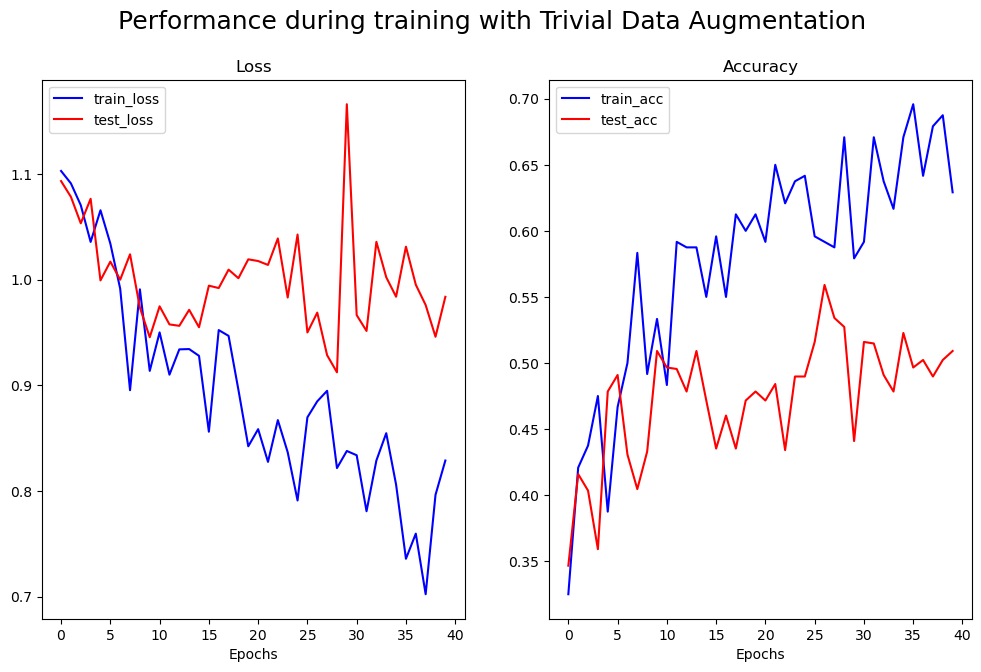

In [64]:
plot_loss_curves(results1)
plt.suptitle('Performance during training with Trivial Data Augmentation', fontsize=18);

This type of data augmentation does not help. In fact, we are overfitting! Could try some other types (that make more sense given the data) like shearing / rotation / scaling / cropping / etc. But the model without any data augmentation does quite well on this data set. Better to move on to a more interesting one - maybe Food101, or something else.

<hr style="border:1px solid black">

# 6. Predict on custom image with model0

In [65]:
custom_img_path = image_path / "04-pizza-dad.jpeg"

custom_image = torchvision.io.read_image(str(custom_img_path)).type(torch.float32)/255

In [66]:
custom_image.shape, custom_image.dtype

(torch.Size([3, 4032, 3024]), torch.float32)

In [67]:
# Use torchvision's resize transfomr to make image right size for model.

resize_transform = transforms.Resize(size=(64,64))

print(f"Custom image before resize: {custom_image.shape}")
custom_imageT = resize_transform(custom_image)

print(f"Custom image after resize: {custom_imageT.shape}")

Custom image before resize: torch.Size([3, 4032, 3024])
Custom image after resize: torch.Size([3, 64, 64])


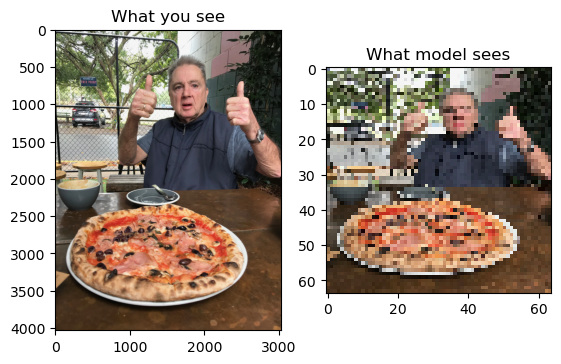

In [83]:
# Plot image before and after resize transform

plt.subplot(121)
hf.imshow_img(custom_image)
plt.title('What you see')

plt.subplot(122)
hf.imshow_img(custom_imageT)
plt.title('What model sees');

In [69]:
# Make prediction using model for custom image

model0.eval()

with torch.inference_mode():
    y_logit = model0(custom_imageT.unsqueeze(0).to(device))

print(f"Prediction = {class_names[y_logit.argmax(dim=1)]}")

Prediction = pizza


In [70]:
print(f"Probabilities of classes: {class_names} are: \n                   {y_logit.softmax(dim=1)}")

Probabilities of classes: ['pizza', 'steak', 'sushi'] are: 
                   tensor([[0.8364, 0.1319, 0.0316]])


In [71]:
def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
    """
    Makes a prediction on target image with trained model and plots image and prediction
    """

    # load in image from path using torchvision's read_image, convert its type and divide by 255 to scale values between [0,1]
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)/255

    # pass image through transform if exists.
    if transform:
        target_image = transform(target_image)

    # put model on device
    model.to(device)

    # Make prediction with model in eval mode and inference context tracker on.
    model.eval()
    with torch.inference_mode():
        y_logit = model(target_image.unsqueeze(0).to(device))

    # Convert raw model output to probability and prediction
    y_prob = y_logit.softmax(dim=1)
    y_pred = y_prob.argmax(dim=1)

    # Plot
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[y_pred.cpu()]} | Prob: {y_prob.max().cpu():.3f}"
    else: 
        title = f"Pred: {y_pred} | Prob: {y_prob.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);


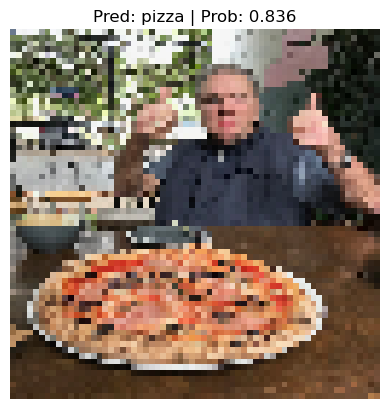

In [72]:
custom_img_path = image_path / "04-pizza-dad.jpeg"

resize_transform = transforms.Resize(size=(64,64))

pred_and_plot_image(model = model0,
                    image_path = custom_img_path,
                    class_names = class_names,
                    transform = resize_transform,
                    device = device)